In [1]:
out_dir='/data/fastfmri_toolbox_test_data/oscprep_grayords_fmapless/first_level_analysis'
!rm -rf {out_dir} {out_dir}_NIFTI {out_dir}_CIFTI
!rm /tmp/*nii*

rm: cannot remove '/tmp/*nii*': No such file or directory


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys, os

sys.path.append('/opt/app')

from pathlib import Path

# For plotting
cm = 1/2.54

In [3]:
oscprep_dir = "/data/fastfmri_toolbox_test_data/oscprep_grayords_fmapless"
sub_dir = 'bold_preproc'

# bold labels
sub_id = '002'
ses_id = '01'
task_id = 'entrainQ1'
run_id = '01'

# task parameters
search_frequencies = [.125, .2]
time_window = (40, 14+205) # seconds

bold_nifti_path = Path(
    f"/data/fastfmri_toolbox_test_data/oscprep_grayords_fmapless/bold_preproc/sub-{sub_id}/" \
    f"ses-{ses_id}/func/sub-{sub_id}_ses-{ses_id}_task-{task_id}_acq-mb4_dir-RL_run-{run_id}" \
    "_space-T1w_desc-preproc_bold.nii.gz"
)
mask_nifti_path = Path(
    f"/data/fastfmri_toolbox_test_data/oscprep_grayords_fmapless/bold_preproc/sub-{sub_id}/" \
    f"ses-{ses_id}/func/sub-{sub_id}_ses-{ses_id}_task-{task_id}_acq-mb4_dir-RL_run-{run_id}" \
    "_space-T1w_desc-boldref_brainmask.nii.gz"
)
bold_dtseries_path = Path(
    f"/data/fastfmri_toolbox_test_data/oscprep_grayords_fmapless/bold_preproc/sub-{sub_id}/" \
    f"ses-{ses_id}/func/sub-{sub_id}_ses-{ses_id}_task-{task_id}_acq-mb4_dir-RL_run-{run_id}" \
    "_desc-preproc_bold.dtseries.nii"
)

for _path in [bold_nifti_path, mask_nifti_path,bold_dtseries_path]:
    assert _path.exists(), f"{_path} does not exist."

In [4]:
def create_temp_file(suffix):
    import tempfile
    temp_file = tempfile.NamedTemporaryFile(suffix=suffix, delete=False)
    temp_file.close()
    return temp_file.name

def convert_niftis_to_ciftis(root_directory, template_cifti, TR):

    import os
    import glob

    # Define the pattern to search for 'nii.gz' files
    file_pattern = '**/*.nii.gz'

    # Use glob to search for files matching the pattern in the directory tree
    matching_files = glob.glob(os.path.join(root_directory, file_pattern), recursive=True)
    
    for nifti in matching_files:
        if nifti.endswith('bold.nii.gz'):
            cmd = f"wb_command -cifti-convert -from-nifti {nifti} {template_cifti} {nifti.replace('.nii.gz','.dtseries.nii')} -reset-timepoints {TR} 0"
        else:
            cmd = f"wb_command -cifti-convert -from-nifti {nifti} {template_cifti} {nifti.replace('.nii.gz','.dscalar.nii')} -reset-scalars"
            
        os.system(cmd)
        os.system(f"rm {nifti}")

    return matching_files

def build_design_matrix(time_window, search_frequencies, bold_path, show_flag = False):
    
    from fastfmri_toolbox.modelling.design_matrix import DesignMatrix
    from fastfmri_toolbox.modelling.design_matrix import (
        FrequencyRegressors, 
        DriftRegressors
    )
    
    dm = DesignMatrix(time_window, search_frequencies, bold_path = bold_path)
    dm.add_regressor(FrequencyRegressors(search_frequencies, dm.time_points))
    dm.add_regressor(DriftRegressors(dm.time_points, high_pass_threshold=.01, add_constant = True))
    
    design_matrix = dm.build_design_matrix()
    n_regressors = design_matrix.shape[-1]
    
    if show_flag:
        dm.plot_design_matrix()
        
    return design_matrix

def run_glm(time_window, search_frequencies, bold_path, mask_path, image_type, design_matrix, outdir):
    
    import nibabel as nib
    import numpy as np
    
    from fastfmri_toolbox.modelling.first_level_analysis import FirstLevelAnalysis
    
    from copy import copy
    copy_bold_path = copy(bold_path)
    
    if image_type == 'CIFTI':
        # Track all cmds in a list
        workflows = []
        # Check dtseries.nii exists
        bold_dtseries_path = Path(str(bold_path).replace('space-T1w_','').replace('nii.gz','dtseries.nii'))
        assert bold_dtseries_path.exists(), f"{bold_dtseries_path} does not exist."        
        # Convert cifti to dummy-nifti
        tmp_bold_path = create_temp_file('.nii.gz')
        _cmd = f"wb_command -cifti-convert -to-nifti {bold_dtseries_path} {tmp_bold_path}"
        workflows.append(_cmd)
        # rename `bold_path` to bids appropriate labelling
        bold_path_stem = Path(copy_bold_path).stem.replace('nii',tmp_bold_path.split('/')[-1])
        bold_path = Path(f"/tmp/{bold_path_stem}")
        _cmd = f"mv {tmp_bold_path} {bold_path}"
        workflows.append(_cmd)
        # Create mask for dummy-nifti 
        mask_path = create_temp_file('.nii.gz')
        _cmd = f"fslmaths {bold_path} -Tmean -bin {mask_path}"
        workflows.append(_cmd)
        
        # Test mask
        """
        mask_dtseries_path = create_temp_file('.dscalar.nii')
        _cmd = f"wb_command -cifti-convert -from-nifti {mask_path} {bold_dtseries_path} {mask_dtseries_path} -reset-scalars"
        workflows.append(_cmd)
        """
        # Run
        for cmd in workflows:
            val = os.system(cmd)
            if val == 0:
                pass
            else:
                sys.exit(f"Command error:\n{cmd}\nExiting.")
                
        # Add an empty dimension back to `mask_path`
        mask_img = nib.load(mask_path)
        mask_data = mask_img.get_fdata()[:,:,np.newaxis]
        mask_img = nib.Nifti1Image(mask_data, affine=mask_img.affine, header=mask_img.header)
        nib.save(mask_img, mask_path)
    
    # Load TR
    TR = float(nib.load(copy_bold_path).header.get_zooms()[-1])
    
    # Set-up first-level analysis
    fla = FirstLevelAnalysis(
        derivatives_dir = f"{outdir}_{image_type}",
        bold_path = bold_path,
        mask_path = mask_path,
        design_matrix = design_matrix,
        time_window = time_window,
        search_frequencies = search_frequencies,
        TR = TR,
    )
    
    # Run
    fla.run_frequency_glm(save_windowed_bold = True, save_predicted = True, save_residual = True,)
    
    if image_type == 'CIFTI':
        # clean-up
        convert_niftis_to_ciftis(f"{outdir}_{image_type}", bold_dtseries_path, TR)
        for p in [bold_path, mask_path]:
            os.system(f"rm {p}")

NIFTI


/usr/local/lib/python3.10/dist-packages/nilearn/glm/_utils.py:344: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


CIFTI
CPU times: user 2min 7s, sys: 52.2 s, total: 2min 59s
Wall time: 2min 8s


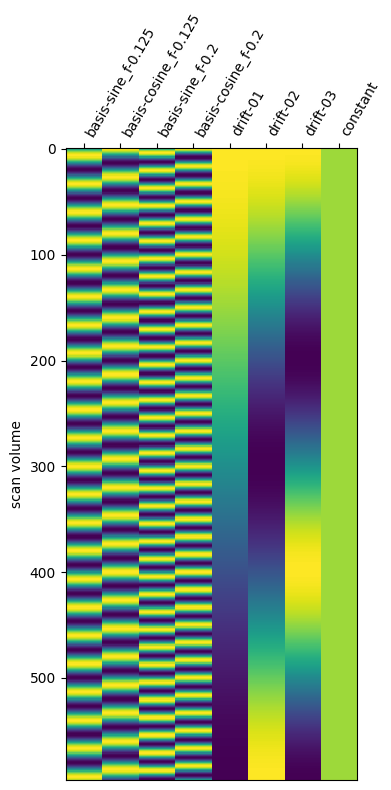

In [5]:
%%time

# Build design matrix
design_matrix = build_design_matrix(time_window, search_frequencies, bold_nifti_path, show_flag = True)

# Fit and run frequency-based GLM
for image_type in ['NIFTI','CIFTI']:
    print(image_type)
    run_glm(time_window, search_frequencies, bold_nifti_path, mask_nifti_path, image_type, design_matrix, out_dir)

In [6]:
!tree /data/fastfmri_toolbox_test_data/oscprep_grayords_fmapless/first*

/data/fastfmri_toolbox_test_data/oscprep_grayords_fmapless/first_level_analysis_CIFTI
└── sub-002
    └── ses-01
        └── task-entrainQ1
            └── run-01
                └── GLM
                    ├── basis-cosine_f-0.125_effect_size.dscalar.nii
                    ├── basis-cosine_f-0.125_effect_variance.dscalar.nii
                    ├── basis-cosine_f-0.125_p_value.dscalar.nii
                    ├── basis-cosine_f-0.125_stat.dscalar.nii
                    ├── basis-cosine_f-0.125_z_score.dscalar.nii
                    ├── basis-cosine_f-0.2_effect_size.dscalar.nii
                    ├── basis-cosine_f-0.2_effect_variance.dscalar.nii
                    ├── basis-cosine_f-0.2_p_value.dscalar.nii
                    ├── basis-cosine_f-0.2_stat.dscalar.nii
                    ├── basis-cosine_f-0.2_z_score.dscalar.nii
                    ├── basis-sine_f-0.125_effect_size.dscalar.nii
                    ├── basis-sine_f-0.125_effect_variance.dscalar.nii
                 